# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

import plotly
import plotly.express as px

from termcolor import colored, cprint

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

✍ Начнём наше исследование со знакомства с данными.

**В целом данные можно разделить на несколько групп.**

**Данные о клиентах банка:**

- age (возраст);
- job (сфера занятости);
- marital (семейное положение);
- education (уровень образования);
- default (имеется ли просроченный кредит);
- housing (имеется ли кредит на жильё);
- loan (имеется ли кредит на личные нужды);
- balance (баланс).

**Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:**

- contact (тип контакта с клиентом);
- month (месяц, в котором был последний контакт);
- day (день, в который был последний контакт);
- duration (продолжительность контакта в секундах).

**Прочие признаки:**

- campaign (количество контактов с этим клиентом в течение текущей кампании);
- pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);
- previous (количество контактов до текущей кампании)
- poutcome (результат прошлой маркетинговой кампании).

**Целевая переменная **deposit**, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.**

In [2]:
df = pd.read_csv('data/bank_fin.csv', sep = ';')

In [3]:
# исследуем данные на предмет пропусков
print('Проверим признаки на наличие пропусков:','\n')
print(df.isnull().sum())

Проверим признаки на наличие пропусков: 

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64


✍ Пропущенные (неизвестные) значения могут присутствовать неявным образом. Это значит, что они могут быть закодированы каким-то словом или набором символов. Часто это не является проблемой, но это необходимо выявить. В наших данных именно такая ситуация (например, в признаке со сферой занятости)

In [4]:

print((df['job'].value_counts()))


management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64


✍ В категориальных признаках пропущенным значением можно считать категорию обозначенную словом 'unknown'. Такая категория присутствует во многих признаках в наших данных.

_______________

✍ В признаке **balance** содержится лишняя запятая и знак доллара. По этой причине этот признак не считывается как число. Обработаем данные этого признака так, чтобы он был преобразован в тип float.

In [5]:
df['balance'] = df['balance'].apply(lambda x: x if [x]==[np.nan] else float((x.replace(' ', '')).replace(',', '.').split('$')[0]))


Теперь можно обработать пропуски

In [6]:
# контрольная проверка

print(colored('среднее по признаку balance без обработки пропусков:', 'blue'), round(df['balance'].mean(), 3))

среднее по признаку balance без обработки пропусков: 1529.129


In [7]:
# заменим пропуски на медианные значения по данному признаку
df['balance'] = df['balance'].fillna(df['balance'].median())

In [8]:
# контрольная проверка
print(colored('среднее по признаку balance после обработки пропусков:', 'blue'), round(df['balance'].mean(), 3))

среднее по признаку balance после обработки пропусков: 1526.936


Обработаем пропуски в категориальных признаках

In [9]:
df.education.value_counts()

secondary    5476
tertiary     3689
primary      1500
unknown       497
Name: education, dtype: int64

Обработаем признаки job и education, заменив их на модальные значения

In [10]:
# Подсчитаем модальное значение для обоих признаков
m_job = df['job'].mode()[0]
m_edu = df['education'].mode()[0]

# Заменим unknown на значение которые мы высчитали 
df['job'] = df['job'].apply(lambda x: m_job if x == 'unknown' else x)
df['education'] = df['education'].apply(lambda x: m_edu if x == 'unknown' else x)



Изучим признак, отображающий баланс клиентов, на предмет выбросов. Для обработки одного числового признака достаточно хорошо подходит метод Тьюки.

In [11]:
# для удаления всех выбросов для признака balance воспользуемся функцией
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned
  
outliers, cleaned = outliers_iqr(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


Избавимся от выбросов в наших данных и оставим для дальнейшего анализа очищенную таблицу

In [12]:

df = cleaned

____________
_________________

## Часть 2:  Разведывательный анализ

✍ В данной части проекта необходимо:

* исследовать данные;
* попробовать найти закономерности, позволяющие сформулировать предварительные гипотезы относительно того, какие факторы являются решающими для оформления депозита;
* дополнить анализ визуализациями, иллюстрирующими исследование. 

(10105, 17)
no     5424
yes    4681
Name: deposit, dtype: int64


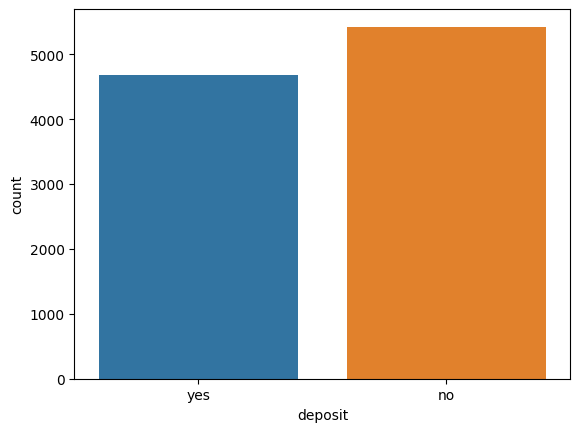

In [13]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат
sns.countplot(data=df, x='deposit')
print(df.shape)
print(df.deposit.value_counts())

Классы сбалансированы. Целевой признак имеет приблизительно равное количество клиентов, которые открыли депозит и тех, которые - не открыли.

________________

Начнём с описательных статистик для количественных переменных.

In [14]:
#рассчитаем описательные статистики для количественных переменных
df.describe()

age       balance           day      duration      campaign  \
count  10105.000000  10105.000000  10105.000000  10105.000000  10105.000000   
mean      40.895497    807.653538     15.590302    368.742603      2.517170   
std       11.734931    994.151966      8.441510    346.651524      2.707159   
min       18.000000  -2049.000000      1.000000      2.000000      1.000000   
25%       32.000000     95.000000      8.000000    137.000000      1.000000   
50%       38.000000    445.000000     15.000000    252.000000      2.000000   
75%       48.000000   1227.000000     22.000000    490.000000      3.000000   
max       95.000000   4063.000000     31.000000   3881.000000     43.000000   

              pdays      previous  
count  10105.000000  10105.000000  
mean      51.319644      0.816230  
std      109.644179      2.243795  
min       -1.000000      0.000000  
25%       -1.000000      0.000000  
50%       -1.000000      0.000000  
75%        2.000000      1.000000  
max      854.000000     58.000000

✍ Проинтерпретируем статистические данные:

1. Age - Возраст клиентов в основном находится в диапазоне от 32 до 49 лет, с средним показателем на отметке 41 год. Это самая активная группа пользователей банковскими услугами. 
2. Balance - 1526 средний баланс на счетах клиентов банка. Имеются клиенты с отрицательным балансом, максимальный баланс 81204. Очевиден сильный разброс данных по этому признаку.
3. Day - видно, что данные распределены равномерно по всем дням месяца.
4. Duration - видимо, это признак подолжительности телефонного разговора в секундах. В основном разговор длился от 2-х до 5-ти минут. Есть уникальные случаи часовых разговоров - видимо, аномалии. Позже можно изучить этот признак более подробно и рассмотреть зависимость целевого признака от этого признака.
5. Campaign - в течении этой компании по привлечению клиентов, в основном, было осуществлено от 1-го до 3-х контактов. Этот признак также имеет выбросы. Позже можно изучить этот признак более подробно и рассмотреть зависимость целевого признака от этого признака.
6. Pdays - в среднем между текущей и предыдущей компанией по привлечению клиентов был сделан перерыв около двух месяцев. Есть очень много отрицательных значений. Возможно, это аномалии, но это также может означать более активное привлечение клиентов с таким признаком - то есть, без перерыва между компаниями. 
7. Privious - этот признак говорит нам, что до текущей кампании по привлечению клиентов с 75% клиентов был осуществлен только 1 контакт. Возможно, это объясняет большое кол-во клиентов для которых не делался перерыв между компаниями (большое кол-во отрицательных показателей в "pdays").
8. Deposite - целевой признак. Классы сбалансированы - примерно равное кол-во клиентов открывших депозит и клиентов, которые не открыли депозит.

Рассмотрим описательные статистики для категориальных переменных.

               job  marital  education default housing   loan   contact  \
count        10105    10105      10105   10105   10105  10105     10105   
unique          11        3          3       2       2      2         3   
top     management  married  secondary      no      no     no  cellular   
freq          2315     5715       5517    9939    5243   8712      7283   

        month poutcome deposit  
count   10105    10105   10105  
unique     12        4       2  
top       may  unknown      no  
freq     2617     7570    5424  


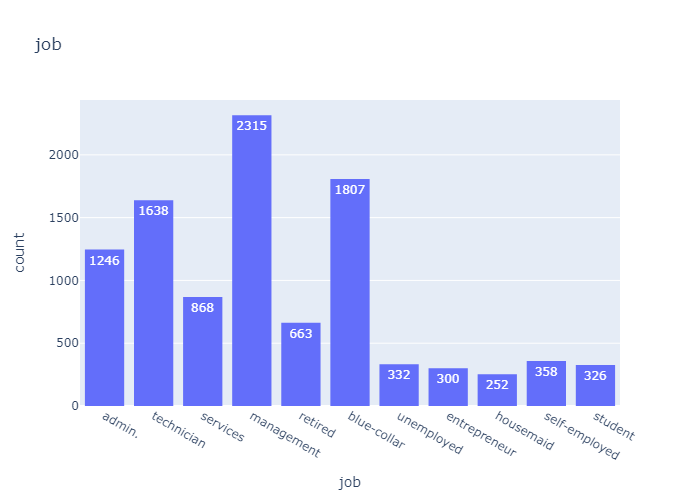

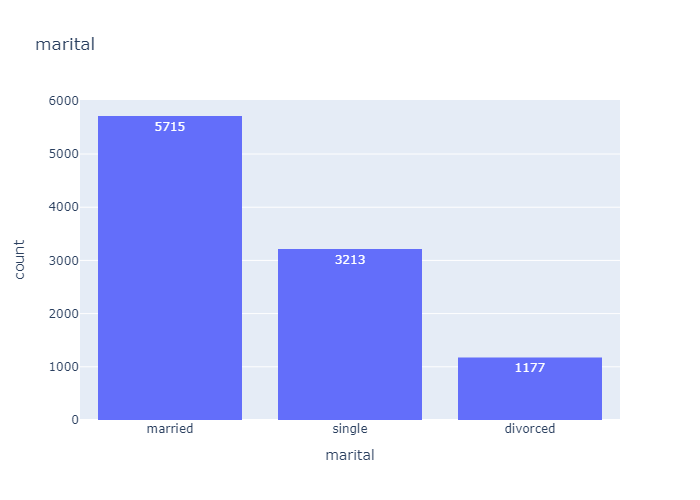

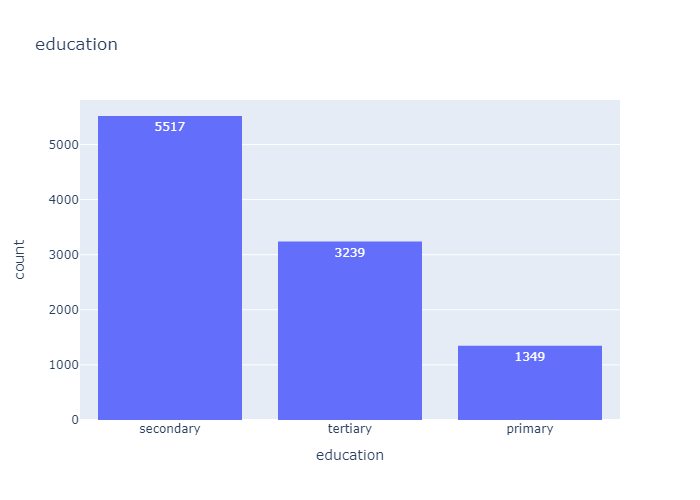

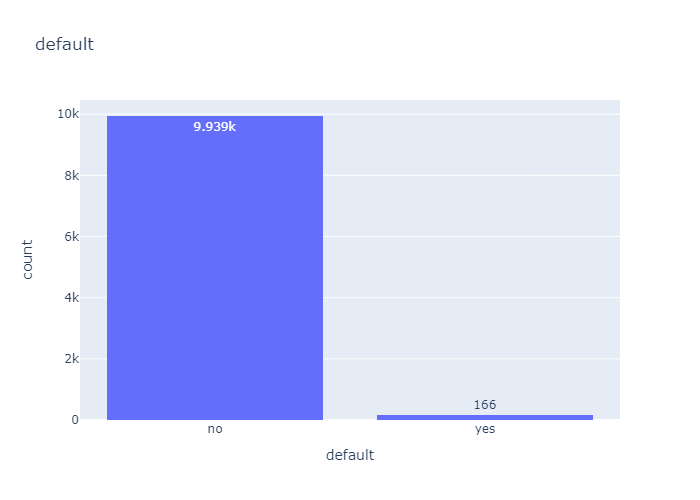

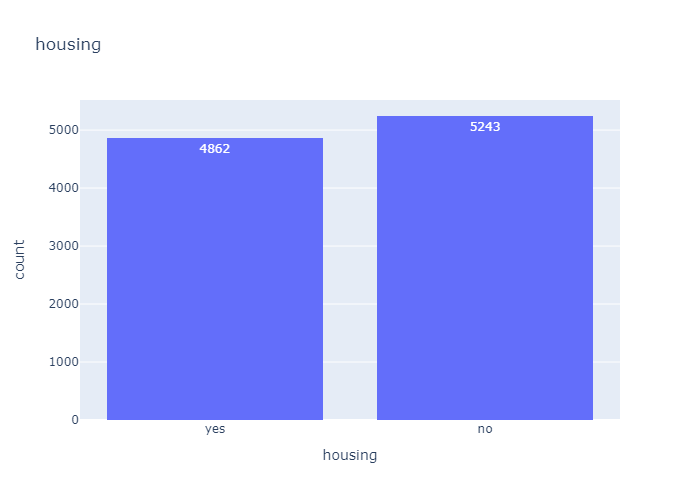

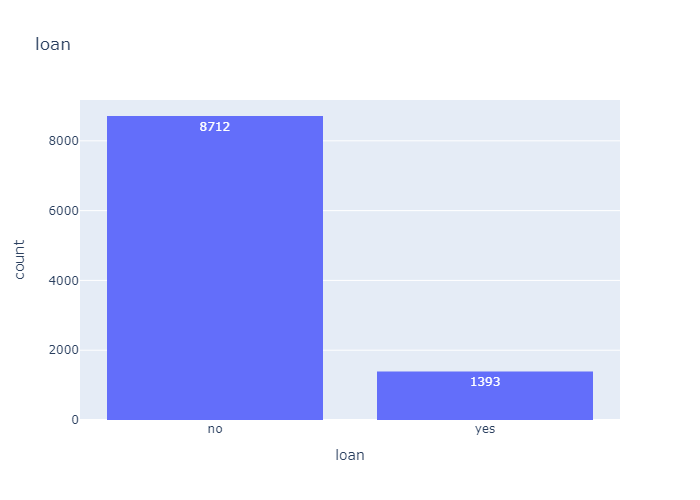

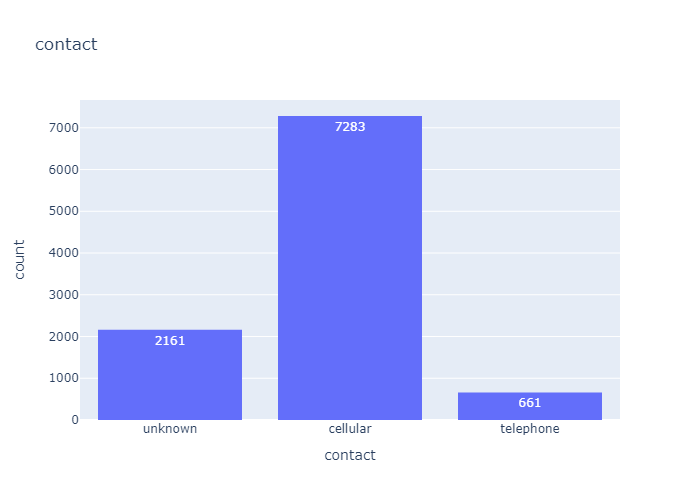

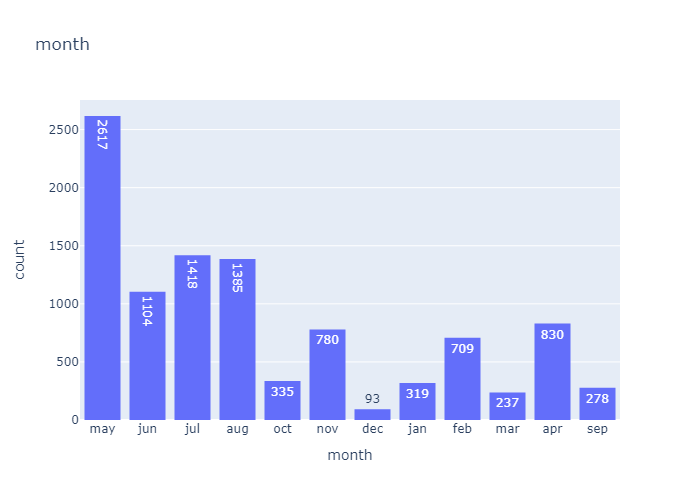

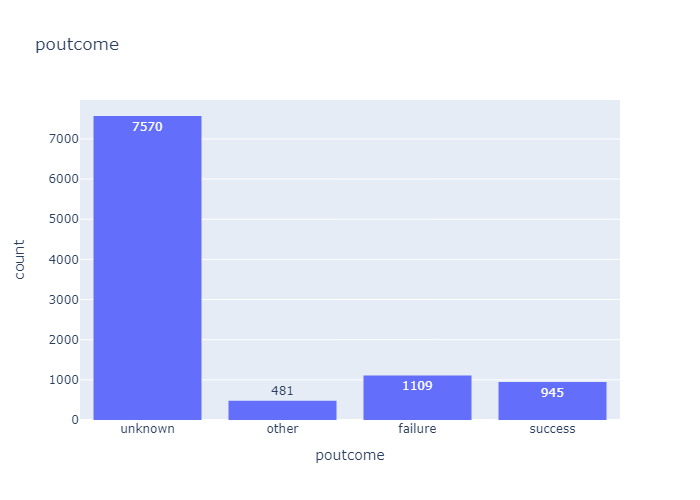

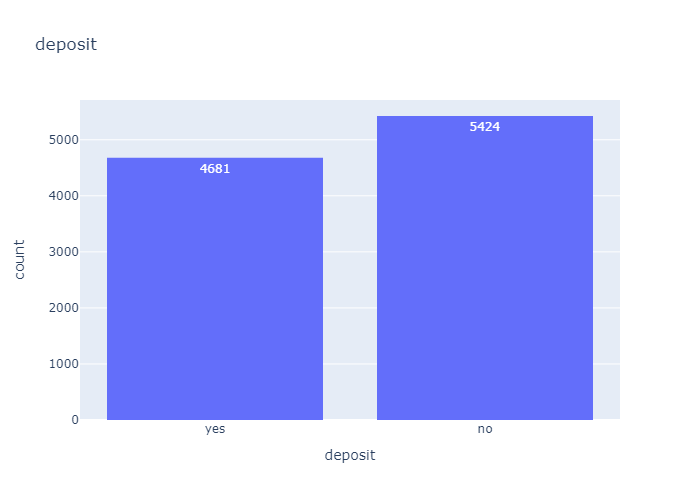

In [15]:
#рассчитаем описательные статистики для категориальных переменных
print(df.describe(include='object'))

#построим визуализации, иллюстрирующие результаты
# выделим категориальные признаки
types = df.dtypes
cat_features = list(types[(types == 'object')].index)
cat_features

# визуализируем распределение признаков в наборе данных
for i in cat_features:
    fig = px.histogram(df, x=i, title=i, text_auto=True)
    fig.show('png')

✍ Составим некоторый портрет типичного клиента банка :

* Типичный клиент банка это индивидуум среднего (30-45 лет) возраста. 
* Большинство имеет работу в сфере management, blue-collar, technical, малочисленно - housemaid, self-employed, entrepreneur. 
* Почти 60% семейные люди(married), 11% - разведённые(divorced)
* Половина с образованием(education) secondary
* Практически никто не имеет просроченной задолженности(default)
* Одинаковое число клиентов, которые имеют/не имеют кредит на жильё(housing), но превалирующее большинство не имеют кредита на личные нужды(loan)(видимо, достаточно обеспечены)



_______________

✍ Рассмотрим категориальные признаки подробнее - узнаем, есть ли разница в результатах текущей маркетинговой кампании и предыдущей. Возможно, люди, которые уже однажды согласились на предложение банка, более склонны принять его вновь.

In [16]:

df.groupby('poutcome')['deposit'].value_counts()

poutcome  deposit
failure   no          562
          yes         547
other     yes         265
          no          216
success   yes         861
          no           84
unknown   no         4562
          yes        3008
Name: deposit, dtype: int64

Для клиентов группы **succes** в предыдущей маркетинговой кампании **poutcome** успех в текущей кампании превалирует над количеством неудач. 

Другими словами, это значит, что клиенты которые открыли депозит в прошлую кампанию, склонны открыть его и в эту кампанию по привлечению клиентов.

**По количеству пропущенных данных этого признака можно сделать некоторые выводы о качестве предыдущей кампании по привлечению клиентов. В большинтсве случаев результат работы не известен.**

__________________

✍ Узнаем, какова зависимость результата маркетинговых кампаний от месяца. Временные периоды, сезоны, близость к каким-то праздникам часто влияют на решение клиентов использовать определённые услуги.

В may месяце больше всего отказывались от открытия депозита.


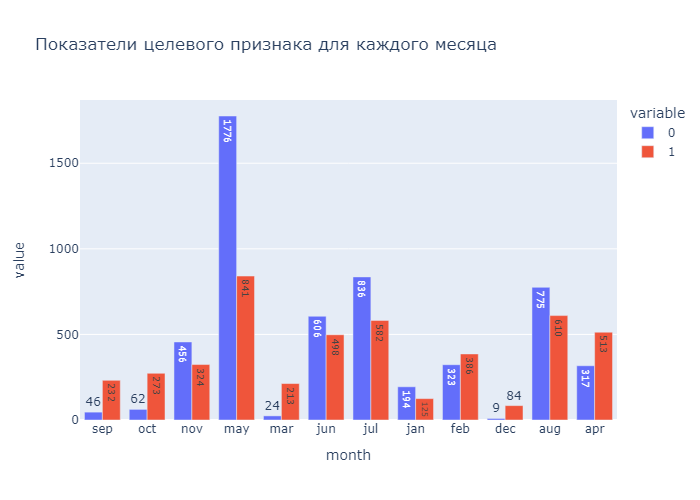

In [17]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
# проведём замену значений целевого признака deposit на булевые: 1 - 'yes', 0 - 'no'
df['deposit'] = df['deposit'].apply(lambda x:int(1) if x == 'yes' else int(0))

percent_failure = round((df.groupby('month')['deposit'].count() - df.groupby('month')['deposit'].sum()) / df.groupby('month')['deposit'].count() * 100).sort_values(ascending=False)
print(f'В {percent_failure.index[0]} месяце больше всего отказывались от открытия депозита.')

fig = px.bar(df.pivot_table(
    values='day',
    index='month',    
    columns='deposit',
    aggfunc='count',
    fill_value=0
).sort_index(ascending=False).reset_index(), x='month', y=[0,1],
             orientation='v',
             text_auto=True,
             barmode='group',
             title='Показатели целевого признака для каждого месяца')
fig.show('png')

Не смотря на наибольшую активность кампании в мае, в этом месяце процент октазов от открытия депозита также наибольший.

_________________

✍ Посмотрим, люди какого возраста чаще открывают депозиты, а какого — реже. Однако, так как возрастной разброс достаточно большой, визуализация для всех возрастов или нахождение статистики для каждого возраста не будет содержательным. 

Разделим людей по возрастным подгруппам и сделаем выводы уже по ним.

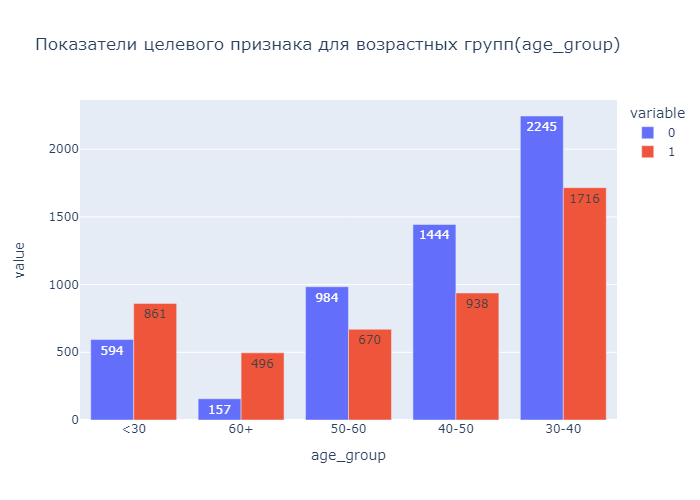

In [18]:
# создадим возрастные группы и определим, в каких группах более склонны открывать депозит, чем отказываться от предложения

def create_age_group(age):
    """ Разбивает клиентов на возрастные группы

    Args:
        age (int): возраст

    Returns:
        age_group(object): возрастная группа
    """
    if age < 30:
        age_group = '<30'
    elif 30 <= age < 40:
        age_group = '30-40'
    elif 40 <= age < 50:
        age_group = '40-50'
    elif 50 <= age < 60:
        age_group = '50-60'
    else:
        age_group = '60+'
    return age_group

df['age_group'] = df['age'].apply(create_age_group)

fig = px.bar(df.pivot_table(
    values='day',
    index='age_group',    
    columns='deposit',
    aggfunc='count',
    fill_value=0
).sort_index(ascending=False).reset_index(), x='age_group', y=[0,1],
             orientation='v',
             text_auto=True,
             barmode='group',
             title='Показатели целевого признака для возрастных групп(age_group)')
fig.show('png')

Наибольшие шансы на открытие депозита имеют возрастные группы: младше 30 и старше 60.

_______________

✍ Посмотрим, как зависит соотношение успешных и неуспешных контактов с клиентами от категорий, к которым относятся клиенты:

* семейное положение;
* уровень образования;
* сфера занятости.

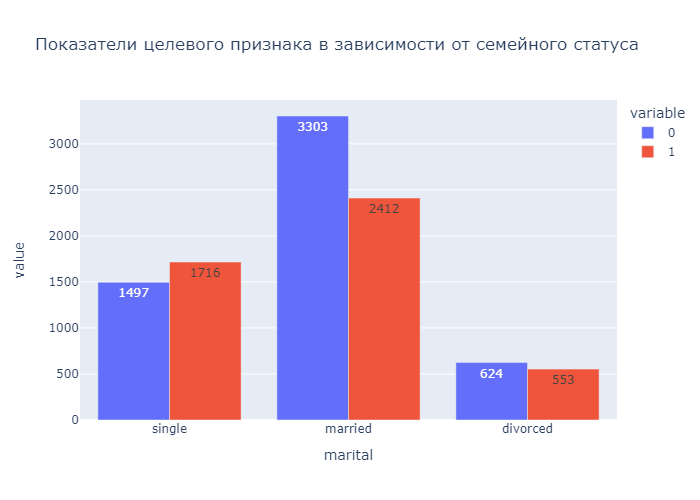

In [19]:
# построим визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса

fig = px.bar(df.pivot_table(
    values='day',
    index='marital',    
    columns='deposit',
    aggfunc='count',
    fill_value=0
).sort_index(ascending=False).reset_index(), x='marital', y=[0,1],
             orientation='v',
             text_auto=True,
             barmode='group',
             title='Показатели целевого признака в зависимости от семейного статуса')
fig.show('png')

Одинокие и разведенные клиенты более предрасположены к открытию депозита. 

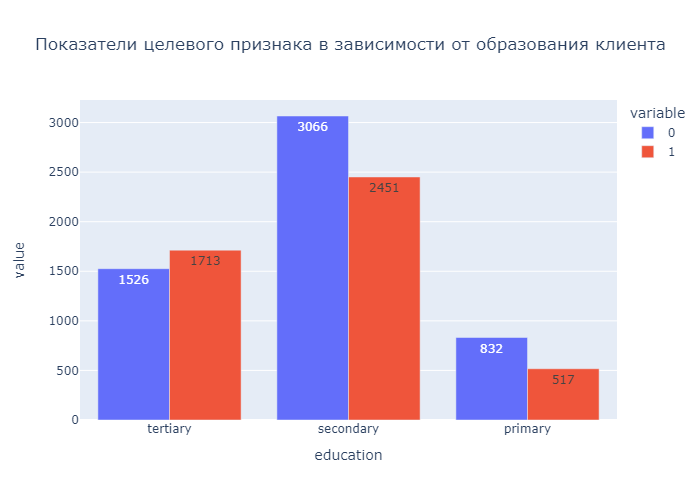

In [20]:
# построим визуализации для открывших и неоткрывших депозит в зависимости от образования
fig = px.bar(df.pivot_table(
    values='day',
    index='education',    
    columns='deposit',
    aggfunc='count',
    fill_value=0
).sort_index(ascending=False).reset_index(), x='education', y=[0,1],
             orientation='v',
             text_auto=True,
             barmode='group',
             title='Показатели целевого признака в зависимости от образования клиента')
fig.show('png')

Клиенты с уровнем образования 'tertiary' более предрасположены к открытию депозита. 

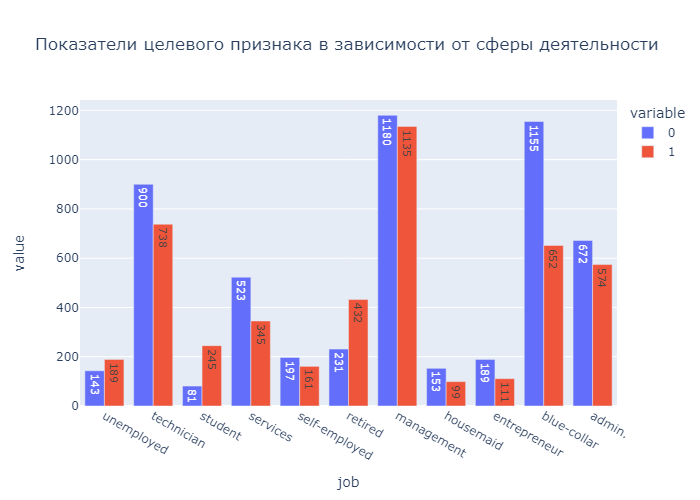

In [21]:
# построим визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
fig = px.bar(df.pivot_table(
    values='day',
    index='job',    
    columns='deposit',
    aggfunc='count',
    fill_value=0
).sort_index(ascending=False).reset_index(), x='job', y=[0,1],
             orientation='v',
             text_auto=True,
             barmode='group',
             title='Показатели целевого признака в зависимости от сферы деятельности')
fig.show('png')

Три категории клиентов - студенты, на пенсии и безработные чаще открывают депозиты.

___________________

✍ Иногда комбинация признаков помогает увидеть интересные взаимосвязи данных. Посмотрим на пересечения категорий. Какие клиенты откывают депозит охотнее: одинокие с высшим образованием или разведённые с более низким уровнем образования? 

In [22]:
# построим сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)

# отфильтруем по целевому признаку. Возьмем клиентов, которые открыли депозит.
p1 = df[df['deposit']==1]
# сформируем таблицу
p1 = df.pivot_table(
    values='job', # название любой колонки из таблицы
    index='education',    
    columns='marital', 
    aggfunc='count',
    fill_value=0)
p1

marital    divorced  married  single
education                           
primary         187      980     182
secondary       653     3119    1745
tertiary        337     1616    1286

In [23]:

fig = px.imshow(p1,
                labels=dict(x="Семейный статус", y="Уровень образования", color="Образование"), #категориальный признак, для которого строится график
                #вывод данных ячеек таблицы
                text_auto=True, 
                
                title='Уровень образования и семейный статус среди клиентов открывших депозит',
                width=1000,
                height=700,
                color_continuous_scale= 'ylorrd',
                #вывод данных ячеек таблицы в процентах до второго знака после запятой
                # text_auto= '.2%',
                aspect='auto')
fig.show()

Комбинировние признаков изменило портрет клиентов потенциально предрасположенных к открытию депозита. 

Всё таки, наиболее предрасположены к открытию депозита клиенты состоящие в браке и имеющие средний уровень образования

________________

✍ Любая кампания по привлечению клиентов это затраты времени и ресурсов. Оплата работы оператора, количество звонков и затраченное время на переговоры это ресурсы. Узнаем насколько длительные уговоры при контакте с клиентом могут способствовать открытию депозита и посмотрим увеличивает ли шансы на открытие депозита количество контактов с клиентом.

In [24]:
fig1 = px.histogram(
    data_frame=df, 
    x='duration', 
    color='deposit',
    histfunc='count',
    title='Зависимость целевого признака от продолжительности контакта', 
    nbins = 100
)

fig1.update_layout(
    yaxis_title="Кол-во человек",
    xaxis_title='Продолжительность контакта в секундах')
fig1.show()

In [25]:
fig1 = px.histogram(
    data_frame=df, 
    x='campaign', 
    color='deposit',
    histfunc='count',
    title='Зависимость целевого признака от количества контактов с клиентом', 
    nbins = 50
)

fig1.update_layout(
    yaxis_title="Кол-во человек",
    xaxis_title='Количество контактов')
fig1.show()

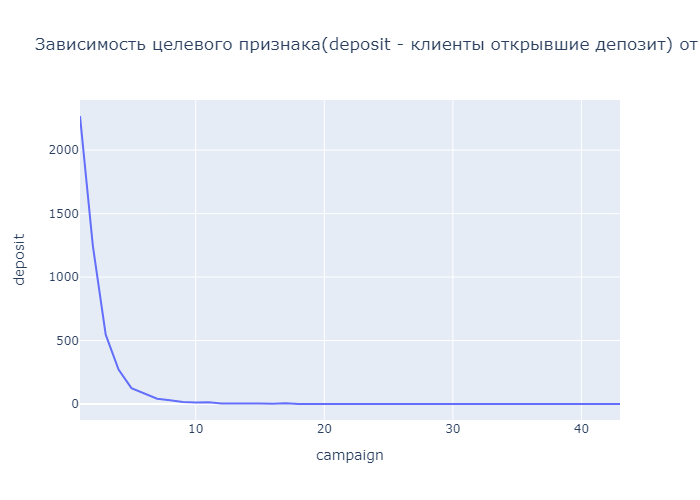

In [26]:


# построим линейный график
fig = px.line(pd.DataFrame(df.groupby('campaign')['deposit'].sum()).reset_index(), x='campaign', y='deposit', title='Зависимость целевого признака(deposit - клиенты открывшие депозит) от количество контактов с этим клиентом в течение текущей кампании(campaign)')
fig.show('png')

✍ Выводы на основе визуализаций:

* Можно выделить две категории занятости (признак "job") - студенты и пенсионеры. Хотя, вероятнее всего, такие категории клиентов не будут слишком прибыльными, шансы на открытие депозита возрастают у клиентов с таким видом занятости.
* В целом, шансы на открытие депозита больше у одиноких, или разведенных клиентов с уровнем образования "tertiary".
* Если у клиента нет кредита на жилье, шансы что он откроет депозит выше.
* Как мы выяснили в **задании 6**, клиенты, согласившиеся открыть депозит по результатам прошлой кампании(success) охотно открывают депозит и в результате новой кампании - т.е. становятся лояльными. Половина клиентов отказавшихся от открытия депозита в прошлую кампанию, изменили своё решение и решили открыть депозит в новую капанию по привлечению клиентов. Не плохой показатель.
* Хотя наибольшая активность кампании наблюдалась в мае, в этом месяце количество открых депозитов меньше, чем в другие месяцы.
* Чем больше клиент расположен к длительному разговору, тем выше вероятность, что он откроет депозит. Контакт более 10 минут дает высокие шансы того, что клиент откроет депозит. 
* Большее кол-во контактов уменьшает шансы открытия депозита. Если клиент не открыл депозит после 2-3 контактов с ним, шансы на отрытие в ближайшем будущем падают. Возможно, есть смысл ограничиться 4 контактами.



__________________
_________________

## Часть 3: преобразование данных

✍ Перед тем как перейти к построению модели, осталось сделать ещё один шаг. Алгоритмы машинного обучения не могут обрабатывать категориальные признаки в их обычном виде. По ходу работы алгоритм считает показатели (например, средние значения), которые можно вычислить только для количественных признаков. 
* Поэтому необходимо преобразовать категориальные признаки в более удобный формат.
* Необходимо масштабировать и трансформировать некоторые признаки для того, чтобы улучшить качество модели.
* Надо отобрать признаки, которые мы будем использовать для обучения модели.

In [27]:
# преобразуйте уровни образования
label_encoder = LabelEncoder() # кодируем порядковым кодировщиком
data_educ = label_encoder.fit_transform(df['education'])
df['education_cod'] = data_educ

# преобразуйте возрастные группы
data_age = label_encoder.fit_transform(df['age_group'])
df['age_group'] = data_age


In [28]:
# преобразуйте бинарные переменные в представление из нулей и единиц
df['housing_bin'] = df['housing'].apply(lambda x: int(1) if x == 'yes' else int(0))
df['default_bin'] = df['default'].apply(lambda x: int(1) if x == 'yes' else int(0))
df['loan_bin'] = df['loan'].apply(lambda x: int(1) if x == 'yes' else int(0))

# удалим колонки которые уже закодировали
df = df.drop(columns=['age', 'education', 'default', 'loan', 'housing'])


In [29]:
types = df.dtypes
cat_features = list(types[(types == 'object')].index)

# создайте дамми-переменные
df = pd.get_dummies(df, columns=cat_features, prefix=cat_features)



______________________

Построим корреляционную матрицу и оценим данные на предмет наличия мультиколлинеарности

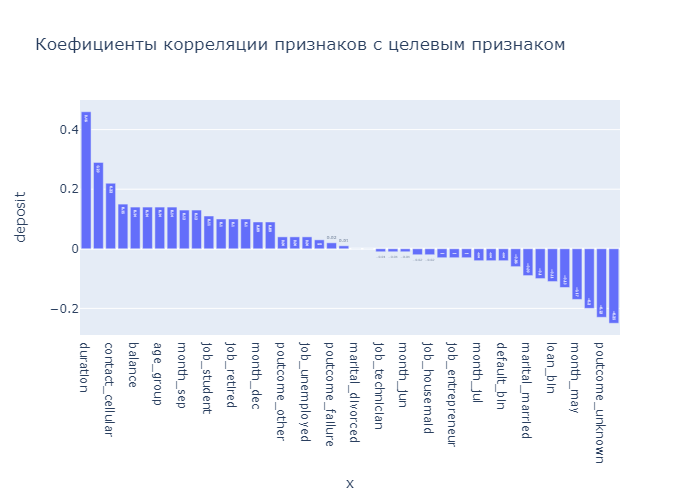

Наиболее высокая корреляция между признаками:


feature 1         feature 2  Corr ind
0   contact_unknown  contact_cellular  0.837885
1  poutcome_unknown             pdays  0.824031
2   marital_married    marital_single  0.779038

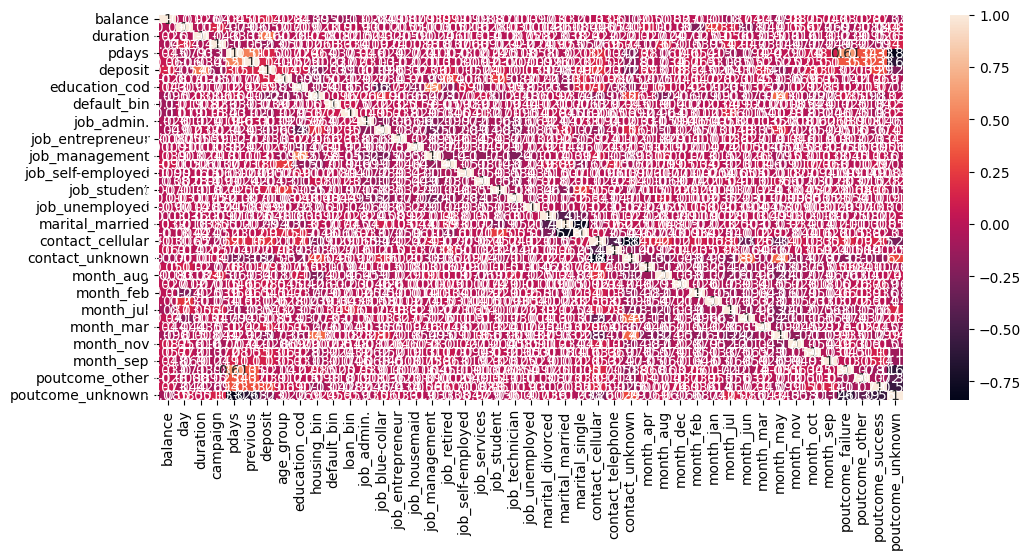

In [30]:

#строим тепловую карту корреляций
fig = plt.figure(figsize=(12, 5))
sns.heatmap(df.corr(), annot=True);

corrs = round(df.corr(), 2).drop('deposit', axis=0)

fig = px.bar(corrs['deposit'].sort_values(ascending=False),
             x=list(corrs['deposit'].sort_values(ascending=False).index),
             y='deposit',
             text_auto=True,
             title='Коефициенты корреляции признаков с целевым признаком'
             )

fig.show('png')

# выведем в все признаки с высокой корреляцией отдельно
corr = df.corr(method='pearson')
print(colored('Наиболее высокая корреляция между признаками:', 'blue'))
corr_unstack = corr.abs().unstack().reset_index()

corr_unstack = corr_unstack.rename(columns = {'level_0' : 'feature 1', 'level_1' : 'feature 2',0 : 'Corr ind' }).\
     sort_values(by = 'Corr ind', ascending = False)
corr_unstack[((corr_unstack['feature 1'] != corr_unstack['feature 2']) & (corr_unstack['Corr ind'] > .7))].\
  iloc[0::2,:].reset_index(drop = True)

Мультиколлинеарность признаков не значительная. Пока оставим всё как есть.

________________________________
____________________

Теперь необходимо определить целевую переменную и предикторы, а также разделить выборку на обучающую и тестовую.

In [31]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [32]:
# рассчитайте необходимые показатели
print(f'Размер тренировочной выборки X_train={X_train.shape}, y_train={y_train.shape[0]}')
print(f'Размер тестовой выборки X_test={X_test.shape}, y_test={y_test.shape[0]}')

Размер тренировочной выборки X_train=(6770, 44), y_train=6770
Размер тестовой выборки X_test=(3335, 44), y_test=3335


__________________

✍ На данный момент у нас достаточно много признаков - не все из них будут важны. Оставим лишь те, которые сильнее всего связаны с целевой переменной и точно будут вносить вклад в повышение качества модели.

С помощью SelectKBest отберём 15 признаков, наилучшим образом подходящих для использования в задаче. Отбор реализуем по обучающей выборке, используя параметр score_func = f_classif.

In [33]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
selector = SelectKBest(score_func = f_classif, k=15)
selector.fit(X_train, y_train)
selector.get_feature_names_out()
selector_col = list(selector.get_feature_names_out())
selector_col

['balance',
 'duration',
 'campaign',
 'pdays',
 'previous',
 'age_group',
 'housing_bin',
 'contact_cellular',
 'contact_unknown',
 'month_mar',
 'month_may',
 'month_oct',
 'month_sep',
 'poutcome_success',
 'poutcome_unknown']

_________________

✍ Теперь данные необходимо нормализовать. Есть разные варианты нормализации, но мы будем использовать min-max-нормализацию. При применении нормализации методом MinMaxScaler все значения признаков будут преобразованы в диапазон [0,1], что означает, что минимальное и максимальное значение признака будет равно 0 и 1 соответственно.


Нормализуем **предикторы** в обучающей и тестовой выборках.

In [34]:
# нормализуйте данные с помощью minmaxsxaler
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
X_train_scal = scaler.fit_transform(X_train)
X_train_scal = pd.DataFrame(X_train_scal, columns=X_train.columns)
X_test_scal = scaler.transform(X_test)
X_test_scal = pd.DataFrame(X_test_scal, columns=X_test.columns)

__________________________________
_____________________________________

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

Для начала реализуем самый простой алгоритм — логистическую регрессию. В качестве алгоритма оптимизации будем использовать 'sag', в качестве значения параметра random_state возьмём число 42 и запустим 1000 итераций.

In [35]:
# обучим логистическую регрессию и рассчитайте метрики качества
log_model = linear_model.LogisticRegression(random_state=42, solver='sag', max_iter=1000)
log_model.fit(X_train_scal, y_train)
y_test_pred = log_model.predict(X_test_scal)
y_train_pred = log_model.predict(X_train_scal)
print(f'Мерики на тестовых даннных:\n {metrics.classification_report(y_test, y_test_pred)}')
print()
print(f'Мерики на тренировочных данных:\n {metrics.classification_report(y_train, y_train_pred)}')

Мерики на тестовых даннных:
               precision    recall  f1-score   support

           0       0.81      0.86      0.83      1790
           1       0.82      0.77      0.80      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.81      0.81      3335
weighted avg       0.82      0.82      0.82      3335


Мерики на тренировочных данных:
               precision    recall  f1-score   support

           0       0.84      0.88      0.86      3634
           1       0.85      0.80      0.82      3136

    accuracy                           0.84      6770
   macro avg       0.84      0.84      0.84      6770
weighted avg       0.84      0.84      0.84      6770



_____________________

Обучим решающие деревья, настроим максимальную глубину

In [36]:

tree_model = tree.DecisionTreeClassifier(random_state=42, criterion='entropy', max_depth=6)
tree_model.fit(X_train_scal, y_train)
y_test_pred = tree_model.predict(X_test_scal)
y_train_pred = tree_model.predict(X_train_scal)
print(f'Мерики на тестовых даннных:\n {metrics.classification_report(y_test, y_test_pred)}')
print()
print(f'Мерики на тренировочных данных:\n {metrics.classification_report(y_train, y_train_pred)}')

Мерики на тестовых даннных:
               precision    recall  f1-score   support

           0       0.85      0.78      0.81      1790
           1       0.76      0.84      0.80      1545

    accuracy                           0.81      3335
   macro avg       0.81      0.81      0.80      3335
weighted avg       0.81      0.81      0.81      3335


Мерики на тренировочных данных:
               precision    recall  f1-score   support

           0       0.87      0.79      0.83      3634
           1       0.78      0.86      0.82      3136

    accuracy                           0.82      6770
   macro avg       0.82      0.82      0.82      6770
weighted avg       0.83      0.82      0.82      6770



✍ Подберем максимальную глубину деревьев, для которой будет максимальное значение метрики accuracy, но при этом ещё не будет наблюдаться переобучения То есть, не будет расти качество на обучающей выборке при неизменном качестве на тестовой. Воспользуемся графиком.

0.83
0.8


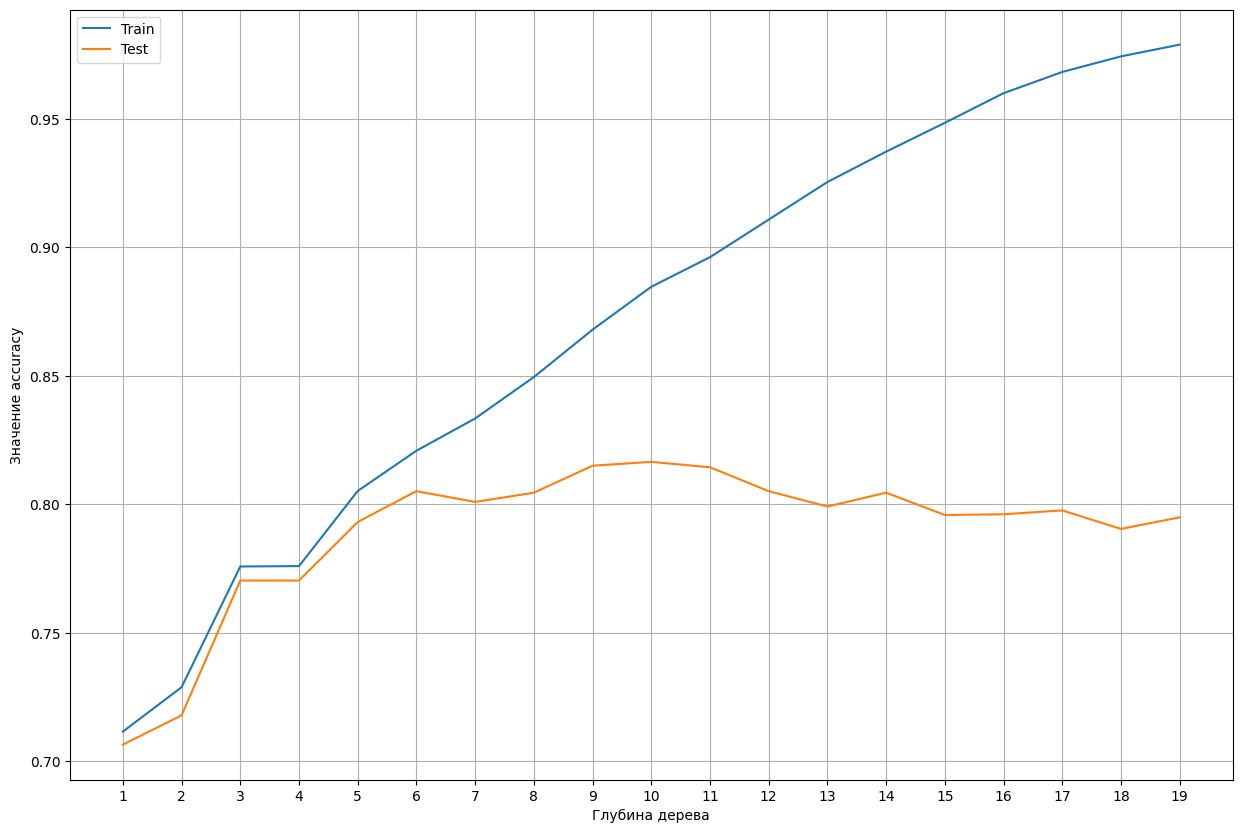

In [37]:
accuracy_test = []
accuracy_train = []
depths = range(1, 20)
for depth in depths:
    dtc = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=depth)
    dtc.fit(X_train_scal, y_train)
    accuracy_train.append(metrics.accuracy_score(y_train, dtc.predict(X_train_scal)))
    accuracy_test.append(metrics.accuracy_score(y_test, dtc.predict(X_test_scal)))
    
fig, ax = plt.subplots(figsize=(15,10))
ax.plot(depths, accuracy_train, label='Train')
ax.plot(depths, accuracy_test, label='Test')
ax.set_xlabel('Глубина дерева')
ax.set_ylabel('Значение accuracy')
ax.xaxis.set_ticks(depths)
ax.grid()
ax.legend()

dtc = tree.DecisionTreeClassifier(criterion='entropy', random_state=42, max_depth=7)
dtc.fit(X_train_scal, y_train)
print(round(metrics.accuracy_score(y_train, dtc.predict(X_train_scal)), 2))
print(round(metrics.accuracy_score(y_test, dtc.predict(X_test_scal)), 2))

Построим график признаков имеющих наибольшее значение для модели.

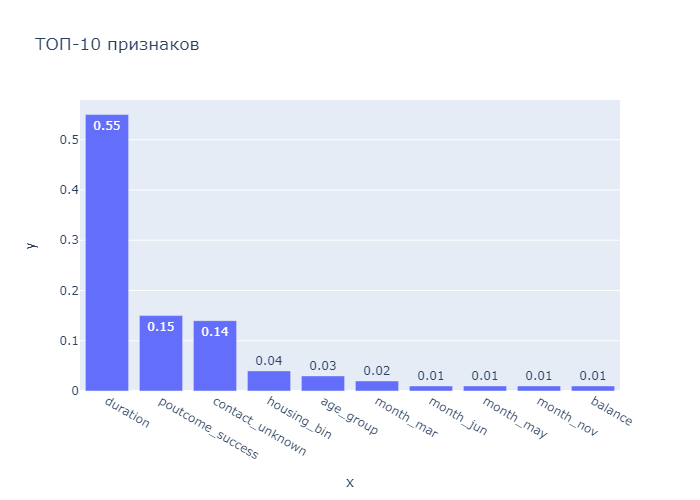

In [38]:
oo = pd.DataFrame([tree_model.feature_importances_], columns=X_train_scal.columns)
fig = px.bar(x = list(oo.loc[0].sort_values(ascending=False)[0:10].index),
    y=round(oo.loc[0].sort_values(ascending=False)[0:10], 2),
    text_auto=True,
    title='ТОП-10 признаков'    
)
fig.show('png')

✍ Как и предполагалось раньше длительность переговоров с клиентом имеет большое значение для предсказания решения клиента, относительно открытия депозита. Подтверждается наше предположение, что клиент, расположенный к длительному разговору с большой долей вероятности откроет депозит. 

Визуализируем дерево решений

In [39]:
#Создаём фигуру для визуализации графа
fig = plt.figure(figsize=(150, 100))
#Строим граф дерева решений
tree.plot_tree(
    tree_model, #объект обученного дерева
    feature_names=X_train_scal.columns, #наименования факторов
    class_names=["0 - Not deposit", "1 - Yes deposit"], #имена классов
    filled=True, #расцветка графа
    fontsize=60    
    );

✍ Разумеется, у каждой модели может быть множество параметров. Перебирать их вручную, чтобы получить наилучшее качество, долго и трудозатратно. Поэтому мы можем использовать оптимизацию: можно перебрать сразу большое количество комбинаций различных параметров и выбрать тот вариант, при котором модель будет давать наиболее точный прогноз.

**Реализуем оптимизацию гиперпараметров с помощью GridSearch**

In [40]:
# подберём оптимальные параметры с помощью gridsearch

from sklearn.model_selection import GridSearchCV
# задаём сетку параметров
param_grid = [
              {'min_samples_split': [2, 5, 7, 10] , # Минимальное количество выборок, необходимое для разделения внутреннего узла
              'max_depth':[3,5,6] # Максимальная глубина дерева
               }              
]

grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(criterion='entropy',
        
        random_state=42, #генератор случайных чисел
        ), 
    param_grid=param_grid, 
    n_jobs = -1,
    scoring='f1'
)  

grid_search.fit(X_train_scal, y_train) 
print(f'Best Hyperparameter Values: {grid_search.best_params_}')
print(f'Best Models:{grid_search.best_estimator_}')
print(f'Best score Cross validation: {grid_search.best_score_:.3f}')
y_test_pred = grid_search.predict(X_test_scal)
y_train_pred = grid_search.predict(X_train_scal)
print(f'Мерики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')
print(f'Мерики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')

Best Hyperparameter Values: {'max_depth': 5, 'min_samples_split': 10}
Best Models:DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=10,
                       random_state=42)
Best score Cross validation: 0.791
Мерики на тестовых даннных
               precision    recall  f1-score   support

           0       0.82      0.79      0.80      1790
           1       0.76      0.80      0.78      1545

    accuracy                           0.79      3335
   macro avg       0.79      0.79      0.79      3335
weighted avg       0.79      0.79      0.79      3335

Мерики на тренировочных данных
               precision    recall  f1-score   support

           0       0.83      0.79      0.81      3634
           1       0.77      0.82      0.80      3136

    accuracy                           0.80      6770
   macro avg       0.80      0.81      0.80      6770
weighted avg       0.81      0.80      0.81      6770



По сути, уже решена задача классификации: мы отобрали признаки, обучили модель, сделали прогноз и оценили его качество. Но попробуем усложнить модель и проверим насколько это повлияет на результат предсказания.

_______________________
_____________________

# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

Объединим простую модель дерева решений и построим модель **Случайный Лес**.

In [41]:
# обучим на наших данных случайный лес
forest_model = ensemble.RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    max_depth=10,
    min_samples_leaf=5,
    criterion='gini'
)
forest_model.fit(X_train_scal, y_train)
y_train_pred = forest_model.predict(X_train_scal)
y_test_pred = forest_model.predict(X_test_scal)
print(f'Мерики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')
print(f'Мерики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')

Мерики на тестовых даннных
               precision    recall  f1-score   support

           0       0.87      0.83      0.85      1790
           1       0.81      0.86      0.83      1545

    accuracy                           0.84      3335
   macro avg       0.84      0.84      0.84      3335
weighted avg       0.84      0.84      0.84      3335

Мерики на тренировочных данных
               precision    recall  f1-score   support

           0       0.90      0.86      0.88      3634
           1       0.85      0.89      0.87      3136

    accuracy                           0.87      6770
   macro avg       0.87      0.88      0.87      6770
weighted avg       0.88      0.87      0.87      6770



_________________

✍ Бустинг (boosting) — это алгоритм построения ансамбля, основанный на последовательном построении "слабых" моделей, причём каждая новая модель пытается уменьшить ошибку предыдущей. После того как все модели обучены, они объединяются в композицию. В качестве базовой модели можно использовать всё что угодно, но общепринятым является использование деревьев решений. Практика показывает, что это наилучший выбор, так как деревья решений очень просты в построении и из всех слабых моделей обладают наилучшей способностью описывать сложные зависимости.

**Градиентный бустинг (Gradient Boosting, GB) — это наиболее обобщённая версия бустинга, закреплённая математическим обоснованием.**

In [42]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

# Создаем модель градиентного бустинга
gb = GradientBoostingClassifier(
    # loss='deviance', #функция потерь
    learning_rate=0.05, #темп обучения
    n_estimators=300, #число деревьев
    max_depth=5, #максимальная глубина дерева
    min_samples_leaf = 5, 
    random_state=42 #генератор случайных чисел
)

# Обучаем модель
gb.fit(X_train_scal, y_train)

# Формируем предсказание для тестовой выборки
gb_pred  = gb.predict(X_test)

y_train_pred = gb.predict(X_train_scal)
y_test_pred = gb.predict(X_test_scal)
print(f'Мерики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')
print(f'Мерики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')

Мерики на тестовых даннных
               precision    recall  f1-score   support

           0       0.88      0.84      0.86      1790
           1       0.82      0.87      0.85      1545

    accuracy                           0.85      3335
   macro avg       0.85      0.85      0.85      3335
weighted avg       0.85      0.85      0.85      3335

Мерики на тренировочных данных
               precision    recall  f1-score   support

           0       0.93      0.90      0.92      3634
           1       0.89      0.92      0.91      3136

    accuracy                           0.91      6770
   macro avg       0.91      0.91      0.91      6770
weighted avg       0.91      0.91      0.91      6770



___________________

✍ **Стекинг (stacking)** — алгоритм построения ансамбля, в котором параллельно и независимо друг от друга обучаются несколько базовых моделей (необязательно одной природы), а их предсказания используются для обучения метамодели (финальная модель) как факторы.

Воспользуемся стекингом, объединив те алгоритмы, которые уже использовали ранее: решающие деревья, логистическую регрессию и градиентный бустинг. В качестве метамодели используйтем модель логистической регрессии.

In [43]:
# объединим уже известные нам алгоритмы с помощью стекинга
from sklearn.ensemble import StackingClassifier
#Создаем список кортежей вида: (наименование модели, модель)
estimators = [
    ('lr', log_model),
    ('dt',  tree_model),
    ('fm', forest_model),
    ('gb', gb)      
]

#Создаем объект класса стекинг
steg_model = StackingClassifier(
    estimators=estimators,
    final_estimator=gb)
    

steg_model.fit(X_train_scal, y_train)
y_train_pred = steg_model.predict(X_train_scal)
y_test_pred = steg_model.predict(X_test_scal)
print(f'Мерики на тестовых даннных\n {metrics.classification_report(y_test, y_test_pred)}')
print(f'Мерики на тренировочных данных\n {metrics.classification_report(y_train, y_train_pred)}')

Мерики на тестовых даннных
               precision    recall  f1-score   support

           0       0.90      0.82      0.86      1790
           1       0.81      0.89      0.85      1545

    accuracy                           0.85      3335
   macro avg       0.85      0.85      0.85      3335
weighted avg       0.86      0.85      0.85      3335

Мерики на тренировочных данных
               precision    recall  f1-score   support

           0       0.94      0.88      0.91      3634
           1       0.87      0.93      0.90      3136

    accuracy                           0.90      6770
   macro avg       0.90      0.91      0.90      6770
weighted avg       0.91      0.90      0.90      6770



______________

✍ Не все признаки одинаково хорошо предсказывают результат маркетинговой кампании. Для того чтобы отобрать наиболее значимые факторы, на которые надо будет обратить внимание при реализации следующей акции, выберем признаки, имеющие наибольшее значение для предсказания.

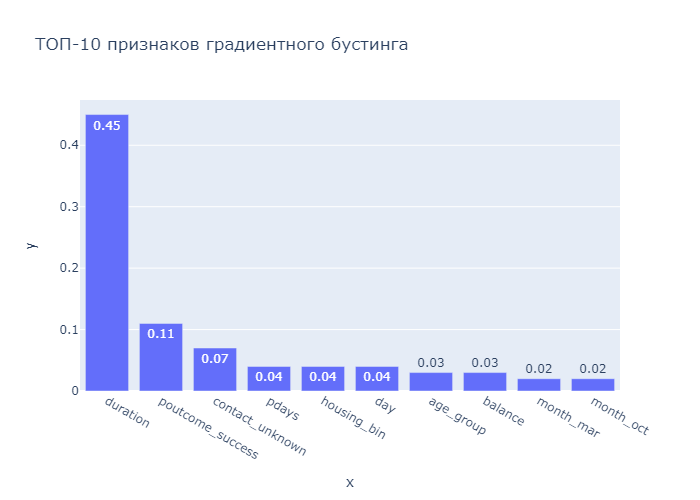

In [44]:
# оценим, какие признаки демонстрируют наибольшую  важность в модели градиентного бустинга
ooo = pd.DataFrame([gb.feature_importances_], columns=gb.feature_names_in_)
fig = px.bar(x = list(ooo.loc[0].sort_values(ascending=False)[0:10].index),
    y=round(ooo.loc[0].sort_values(ascending=False)[0:10], 2),
    text_auto=True,
    title='ТОП-10 признаков градиентного бустинга'    
)
fig.show('png')

✍ Как и ожидалось, все самые важные факторы, которые влияют на решение клиента, относительно открытия депозита, связаны с общением, способом и формой контакта с клиентом. 
* Наиважнейшим фактором является умение общаться с клиентом. Умение привлечь клиента именно теми выгодами открытия депозита, которые будут интересны именно этому конкретному клиенту. Наш анализ подтвердил очевидное: если клиента удалось расположить к содержательному разговору, существенно увеличивается вероятность того, что клиент откроет депозит. 
* Второй фактор зависит от первого: если во время предыдущей кампании с клиентом налажен контакт и он действительно получил предложение, которое было ему интересно, он становится более лоялен банку и склонен доверять рекомендациям работника банка, который уже однажды порекомендовал ему нужное предложение. Соответственно, вероятность того, что такой человек снова воспользуется предложением банка - увеличивается.
* Третий важный фактор снова связан с общением: важна форма контакта с клиентом. В данных зафиксированы три способа контакта: 
   1. телефон; 
   2. сотовый телефон;
   3. "unknown"/форма контакта неизвестна. 

  Именно эта "неизвестная" форма контакта и имеет наибольшее влияние на решение клиента из всех зафиксированных форм общения. К неизвестной форме контакта попробуем применить эвристику: наибольшее воздействие всегда имело личное общение с человеком. Если это не сотовый и не городской телефон; также маловероятна высокая результативность контакта по имэйл, то скорее всего это личное общение. **Можно дать рекомендацию:** в случае открытия депозита, постфактум отмечать был ли фактор общения с работником банка и кем именно, чтобы выделить такого работника. 
* Следующий фактор требует дополнительного исследования, так как в большинстве случаев этот признак имеет отрицательное значение. 
* Важен фактор наличия/отсутствия кредита на жильё. Этот признак требует дополнительного рассмотрения для выявления зависимости. Цель этого исследования не в этом.
* Важен день контакта с клиентом. При дальнейшем анализе можно было бы рассмотреть этот фактор не только как дату и месяц, но добавить и день недели. Возможно, модель делает ошибку и придает большее значение датам с большим числом. Например, 10 сентября может, по ошибке, быть важнее, чем 1 сентября. Логика машины простая 10 > 1, поэтому 10 имеет большее значение.
* Далее по важности идет возрастная группа: Как мы выяснили молодые люди до 30 и пенсионеры открывают депозит чаще. Очевидно, студенты открывают депозит чаще, так как они его ещё не имеют и есть необходимость иметь счет для зачисления стипендии. А пенсионерам необходимо получать пенсию и, возможно, именно в этом банке есть какие-то дополнительные выгоды для этой возрастной группы клиентов.
* Фактор баланса на счету клиента требует дополнительного анализа, чтобы выявить зависимость целевого признака от этого фактора.
* Фактор месяца также имеет не значительное влияние на решение об открытии депозита.

____________

✍ Ранее мы уже рассматривали оптимизацию гиперпараметров при помощи GridSearch. Однако, это не единственный способ. Один из более продвинутых способов — фреймворк Optuna, разработанный специально для оптимизации гиперпараметров. Применим этот способ.

In [45]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna
import optuna
def optuna_rf(trial):
  """Функция, обучающая модель Random Forest
    по переданным гиперпараметрам

  Args:
      trial : класс, от которого вызываются гиперпараметры

  Returns:
      score(float): метрика F1
  """
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1)
  max_depth = trial.suggest_int('max_depth', 10, 30, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)
  
  # создаем модель
  model = forest_model
  
  # обучаем модель 
  model.fit(X_train_scal, y_train)
  y_train_pred = model.predict(X_train)
  score = metrics.f1_score(y_train, y_train_pred)

  return score

# cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=50)

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42)
model.fit(X_train_scal, y_train)
y_test_pred = model.predict(X_test_scal)

score = metrics.f1_score(y_test, y_test_pred)
print(f'Наилучшие значения гиперпараметров {study.best_params}')
print(f'F1 for test data={score:.2f}')
print(f'Accuracy for test data={metrics.accuracy_score(y_test, y_test_pred):.2f}')

[I 2023-10-22 21:36:50,345] A new study created in memory with name: RandomForestClassifier
[I 2023-10-22 21:36:50,989] Trial 0 finished with value: 0.6331516252776096 and parameters: {'n_estimators': 154, 'max_depth': 18, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.6331516252776096.
[I 2023-10-22 21:36:51,567] Trial 1 finished with value: 0.6331516252776096 and parameters: {'n_estimators': 178, 'max_depth': 27, 'min_samples_leaf': 4}. Best is trial 0 with value: 0.6331516252776096.
[I 2023-10-22 21:36:52,161] Trial 2 finished with value: 0.6331516252776096 and parameters: {'n_estimators': 181, 'max_depth': 28, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.6331516252776096.
[I 2023-10-22 21:36:52,801] Trial 3 finished with value: 0.6331516252776096 and parameters: {'n_estimators': 120, 'max_depth': 23, 'min_samples_leaf': 6}. Best is trial 0 with value: 0.6331516252776096.
[I 2023-10-22 21:36:53,426] Trial 4 finished with value: 0.6331516252776096 and parameters: {'n_

Наилучшие значения гиперпараметров {'n_estimators': 154, 'max_depth': 18, 'min_samples_leaf': 6}
F1 for test data=0.84
Accuracy for test data=0.85


______________________
______________

# ВЫВОДЫ:

**Подведем итоги наблюдений и наработок по работе моделей использованных для решения практической задачи.**

Итоговый обзор метрик F1 и Accuracy представим в виде таблицы:
|      **МЕТОД/МЕТРИКИ**         |  **F1** |  **ACCURACY** |
|:-------------------|:------------------|:------------------|
|LogisticRegression|    0.80      |      0.82      |
|DecisionTreeClassifier|       0.80       |   0.81     | 
|RandomForestClassifier  |    0.83       |       0.84       | 
|GradientBoostingClassifier |       **0.85**       |       **0.85**     | 
|StackingClassifier |       **0.85**      |       **0.85**    | 
|RandomForestClassifier whith Optuna |       **0.85**       |       **0.85**    | 

Для решения задачи классификации на предоставленных данных одинаково хорошо себя показали модели бустинга и стэкинга, а также модель случайного леса с подобранными гиперпараметрами методом Optuna. Не удалось выделить какой-то один метод, как более эффективный из этих трёх.

